In [1]:
# for data wrangling
import itertools
import numpy as np
import pandas as pd
# build functions
import build_fns as build
# for neural net
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# for evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# data plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
X_train = pd.read_csv('split_data/X_train.csv')
X_test = pd.read_csv('split_data/X_test.csv')
y_train = pd.read_csv('split_data/y_train.csv')
y_test = pd.read_csv('split_data/y_test.csv')

In [3]:
params = dict(epochs=50, batch_size=32, neurons=50, optimizer='adam', kernel_regularizer=1e-3)

# Helper Functions

## K-Folds Evaluation Function

In [4]:
def cv_eval(model, n_folds, X, y):
    """K-fold validation function for evaluation of a Keras model.
    Arguments:
        model: the model to evaluate.
        n_folds (int): the number of cross-folds.
        X (pandas dataframe): values of the feature variables.
        y (pandas dataframe): values of the classification.
    Returns:
        cms (list): confusion matrix for each cross-fold.
        histories (list): model metrics for each cross-fold.
        tprs (list): the True Positive Rate for each cross-fold.
        base_fpr (list): the cutoff points for the ROC curve.
    """
    kf = StratifiedKFold(n_splits=n_folds, shuffle=False)
    cms = []  # confusion matrix results
    histories = []  # for model analysis
    tprs = []  # for ROC analysis
    base_fpr = np.linspace(0, 1, 101)  # for ROC analysis

    for train, test in kf.split(X, y):
        X_train, X_test = X.iloc[train].values, X.iloc[test].values
        y_train, y_test = y.iloc[train].values, y.iloc[test].values
        # recording model metrics and confusion matrix
        histories.append(model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=0))
        cms.append(confusion_matrix(y_test, model.predict(X_test)))
        # recording for auc
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.
        tprs.append(tpr)

    return cms, histories, tprs, base_fpr

## Confusion Matrix Plotting Function

In [163]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True, cbar=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(4, 3), dpi=300)
    ax1 = fig.add_subplot()
#     ax1.text(-.1, 1.1, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names, rotation=90, verticalalignment='center')
#         plt.yticks([], ['', ''])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    if cbar:
        plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()

    return fig

# 5-Fold Stratified Cross-Validation on Training Data

## 1 Hidden Layer

In [6]:
model1 = KerasClassifier(build_fn=build.hidden1,
                         epochs=params['epochs'],
                         batch_size=params['batch_size'],
                         neurons=params['neurons'],
                         optimizer=params['optimizer'],
                         kernel_regularizer=params['kernel_regularizer']
                        )
cm_results1, history1, tpr1, base_fpr1 = cv_eval(model1, n_folds=5, X=X_train, y=y_train)

In [7]:
cm1 = [[0, 0]]
k, l = 0, 0
for i in cm_results1:
    for j in cm_results1[0]:
        cm1[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm1 = np.array(cm1[0])

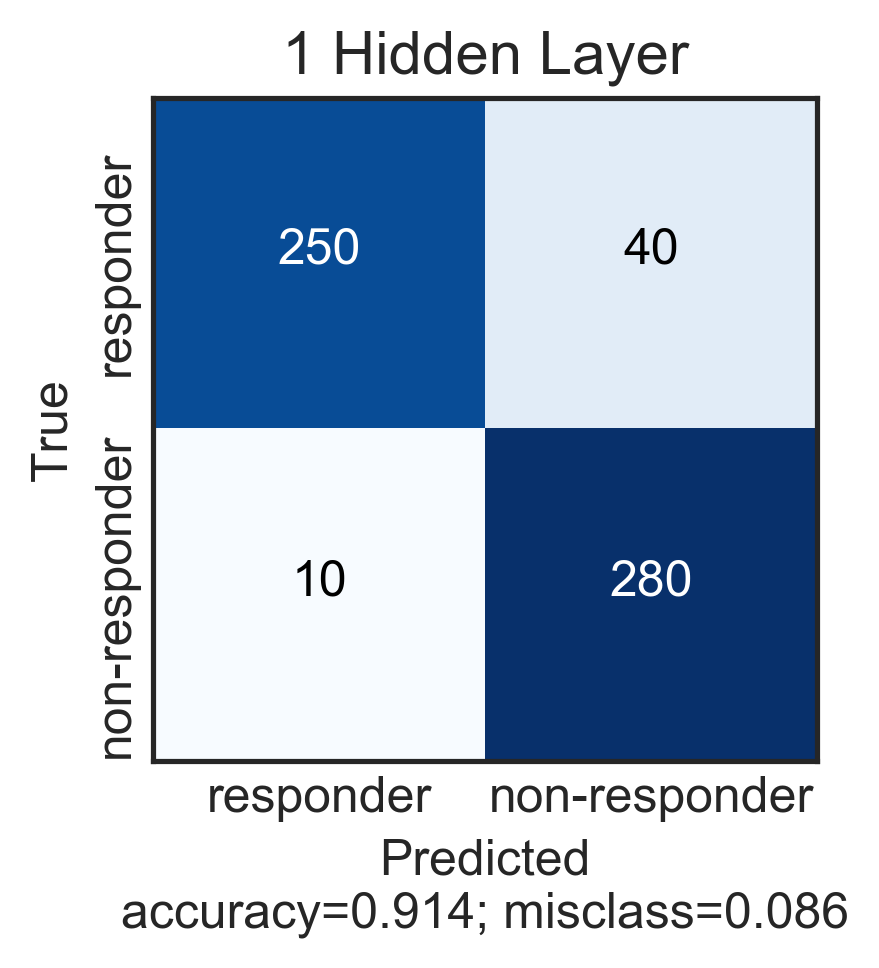

In [164]:
plt.rcParams.update({'font.size': 12})
cm_hidden1 = plot_confusion_matrix(cm1, ['responder', 'non-responder'], title='1 Hidden Layer', normalize=False, cbar=False)

## 5 Hidden Layers

In [9]:
model5 = KerasClassifier(build_fn=build.hidden5,
                         epochs=params['epochs'],
                         batch_size=params['batch_size'],
                         neurons=params['neurons'],
                         optimizer=params['optimizer'],
                         kernel_regularizer=params['kernel_regularizer']
                        )
cm_results5, history5, tprs5, base_fpr5 = cv_eval(model5, n_folds=5, X=X_train, y=y_train)

In [10]:
cm5 = [[0, 0]]
k, l = 0, 0
for i in cm_results5:
    for j in cm_results5[0]:
        cm5[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm5 = np.array(cm5[0])

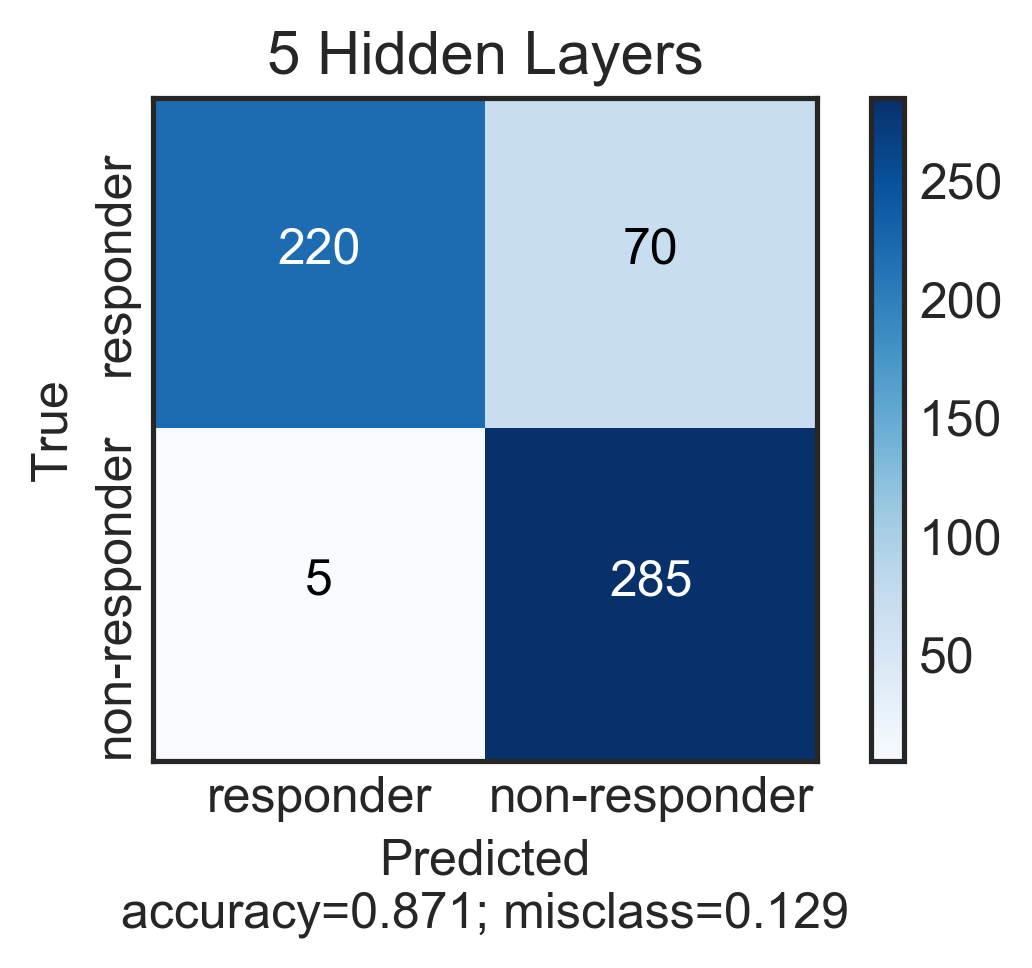

In [141]:
plt.rcParams.update({'font.size': 12})
cm_hidden5 = plot_confusion_matrix(cm5, ['responder', 'non-responder'], title='5 Hidden Layers', normalize=False)

## 10 Hidden Layers

In [12]:
model10 = KerasClassifier(build_fn=build.hidden10,
                          epochs=params['epochs'],
                          batch_size=params['batch_size'],
                          neurons=params['neurons'],
                          optimizer=params['optimizer'],
                          kernel_regularizer=params['kernel_regularizer']
                         )
cm_results10, history10, tprs10, base_fpr10 = cv_eval(model10, n_folds=5, X=X_train, y=y_train)

In [13]:
cm10 = [[0, 0]]
k, l = 0, 0
for i in cm_results10:
    for j in cm_results10[0]:
        cm10[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm10 = np.array(cm10[0])
cm10

array([[270,  20],
       [ 55, 235]])

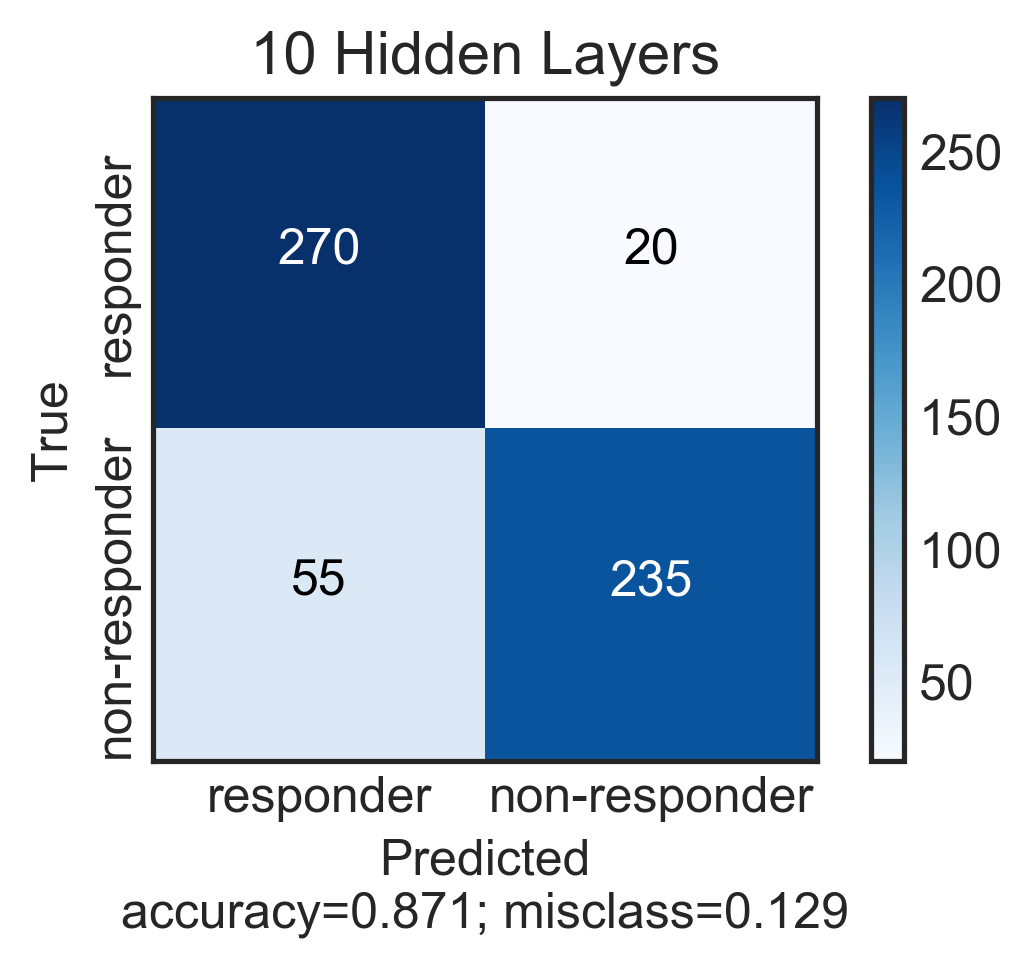

In [142]:
plt.rcParams.update({'font.size': 12})
cm_hidden10 = plot_confusion_matrix(cm10, ['responder', 'non-responder'], title='10 Hidden Layers', normalize=False)

## 15 Hidden Layers

In [15]:
model15 = KerasClassifier(build_fn=build.hidden15,
                          epochs=params['epochs'],
                          batch_size=params['batch_size'],
                          neurons=params['neurons'],
                          optimizer=params['optimizer'],
                          kernel_regularizer=params['kernel_regularizer']
                         )
cm_results15, history15, tprs15, base_fpr15 =cv_eval(model15, n_folds=5, X=X_train, y=y_train)

In [16]:
cm15 = [[0, 0]]
k, l = 0, 0
for i in cm_results15:
    for j in cm_results15[0]:
        cm15[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm15 = np.array(cm15[0])
cm15

array([[  0, 290],
       [  0, 290]])

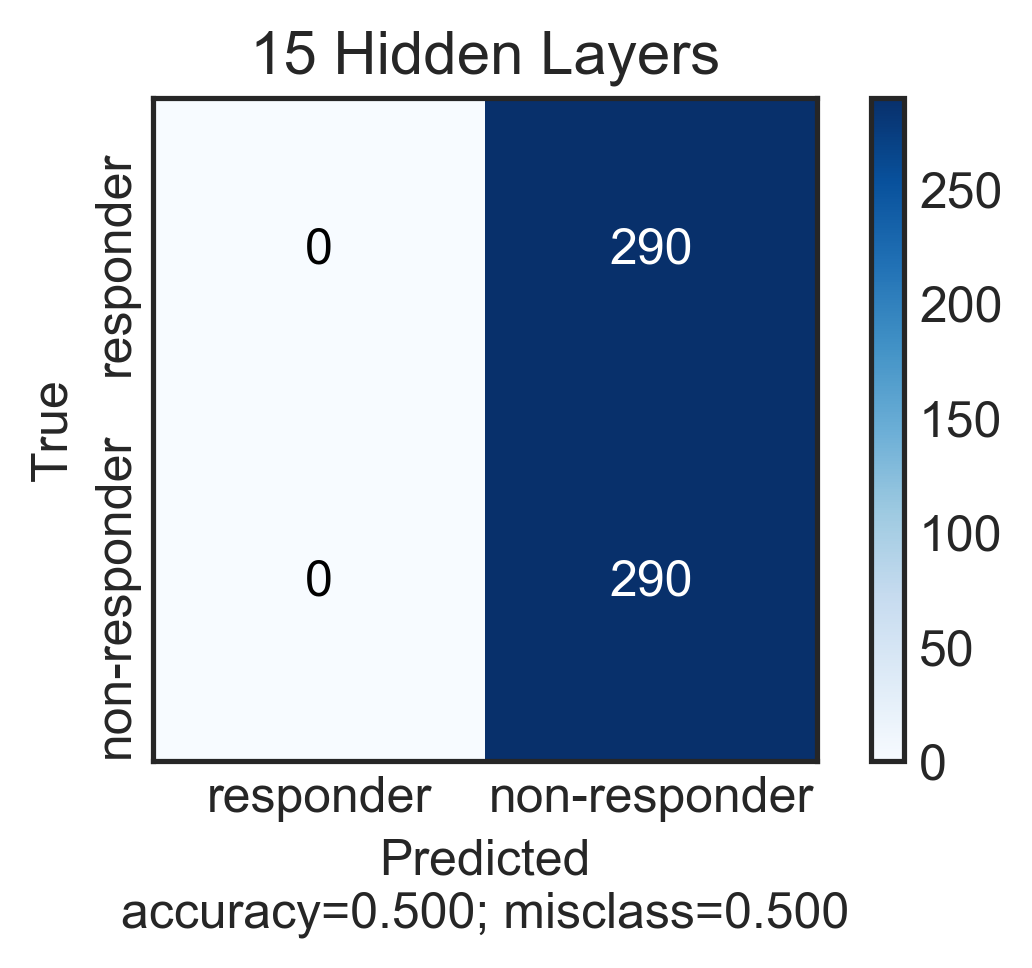

In [143]:
plt.rcParams.update({'font.size': 12})
cm_hidden15 = plot_confusion_matrix(cm15, ['responder', 'non-responder'], title='15 Hidden Layers', normalize=False)

# Comparison Plots

In [181]:
# for 1 hidden layer
tprs1 = np.array(tpr1)
mean_tprs1 = tprs1.mean(axis=0)
std1 = tprs1.std(axis=0)
tprs_upper1 = mean_tprs1 + std1 / np.sqrt(5)
tprs_lower1 = mean_tprs1 - std1 / np.sqrt(5)
auc1 = auc(base_fpr1, mean_tprs1)

In [182]:
# for 5 hidden layers
tprs5 = np.array(tprs5)
mean_tprs5 = tprs5.mean(axis=0)
std5 = tprs5.std(axis=0)
tprs_upper5 = mean_tprs5 + std5 / np.sqrt(5)
tprs_lower5 = mean_tprs5 - std5 / np.sqrt(5)
auc5 = auc(base_fpr5, mean_tprs5)

In [183]:
# for 10 hidden layers
tprs10 = np.array(tprs10)
mean_tprs10 = tprs10.mean(axis=0)
std10 = tprs10.std(axis=0)
tprs_upper10 = mean_tprs10 + std10 / np.sqrt(5)
tprs_lower10 = mean_tprs10 - std10 / np.sqrt(5)
auc10 = auc(base_fpr10, mean_tprs10)

In [184]:
# for 15 hidden layers
tprs15 = np.array(tprs15)
mean_tprs15 = tprs15.mean(axis=0)
std15 = tprs15.std(axis=0)
tprs_upper15 = mean_tprs15 + std15 / np.sqrt(5)
tprs_lower15 = mean_tprs15 - std15 / np.sqrt(5)
auc15 = auc(base_fpr15, mean_tprs15)

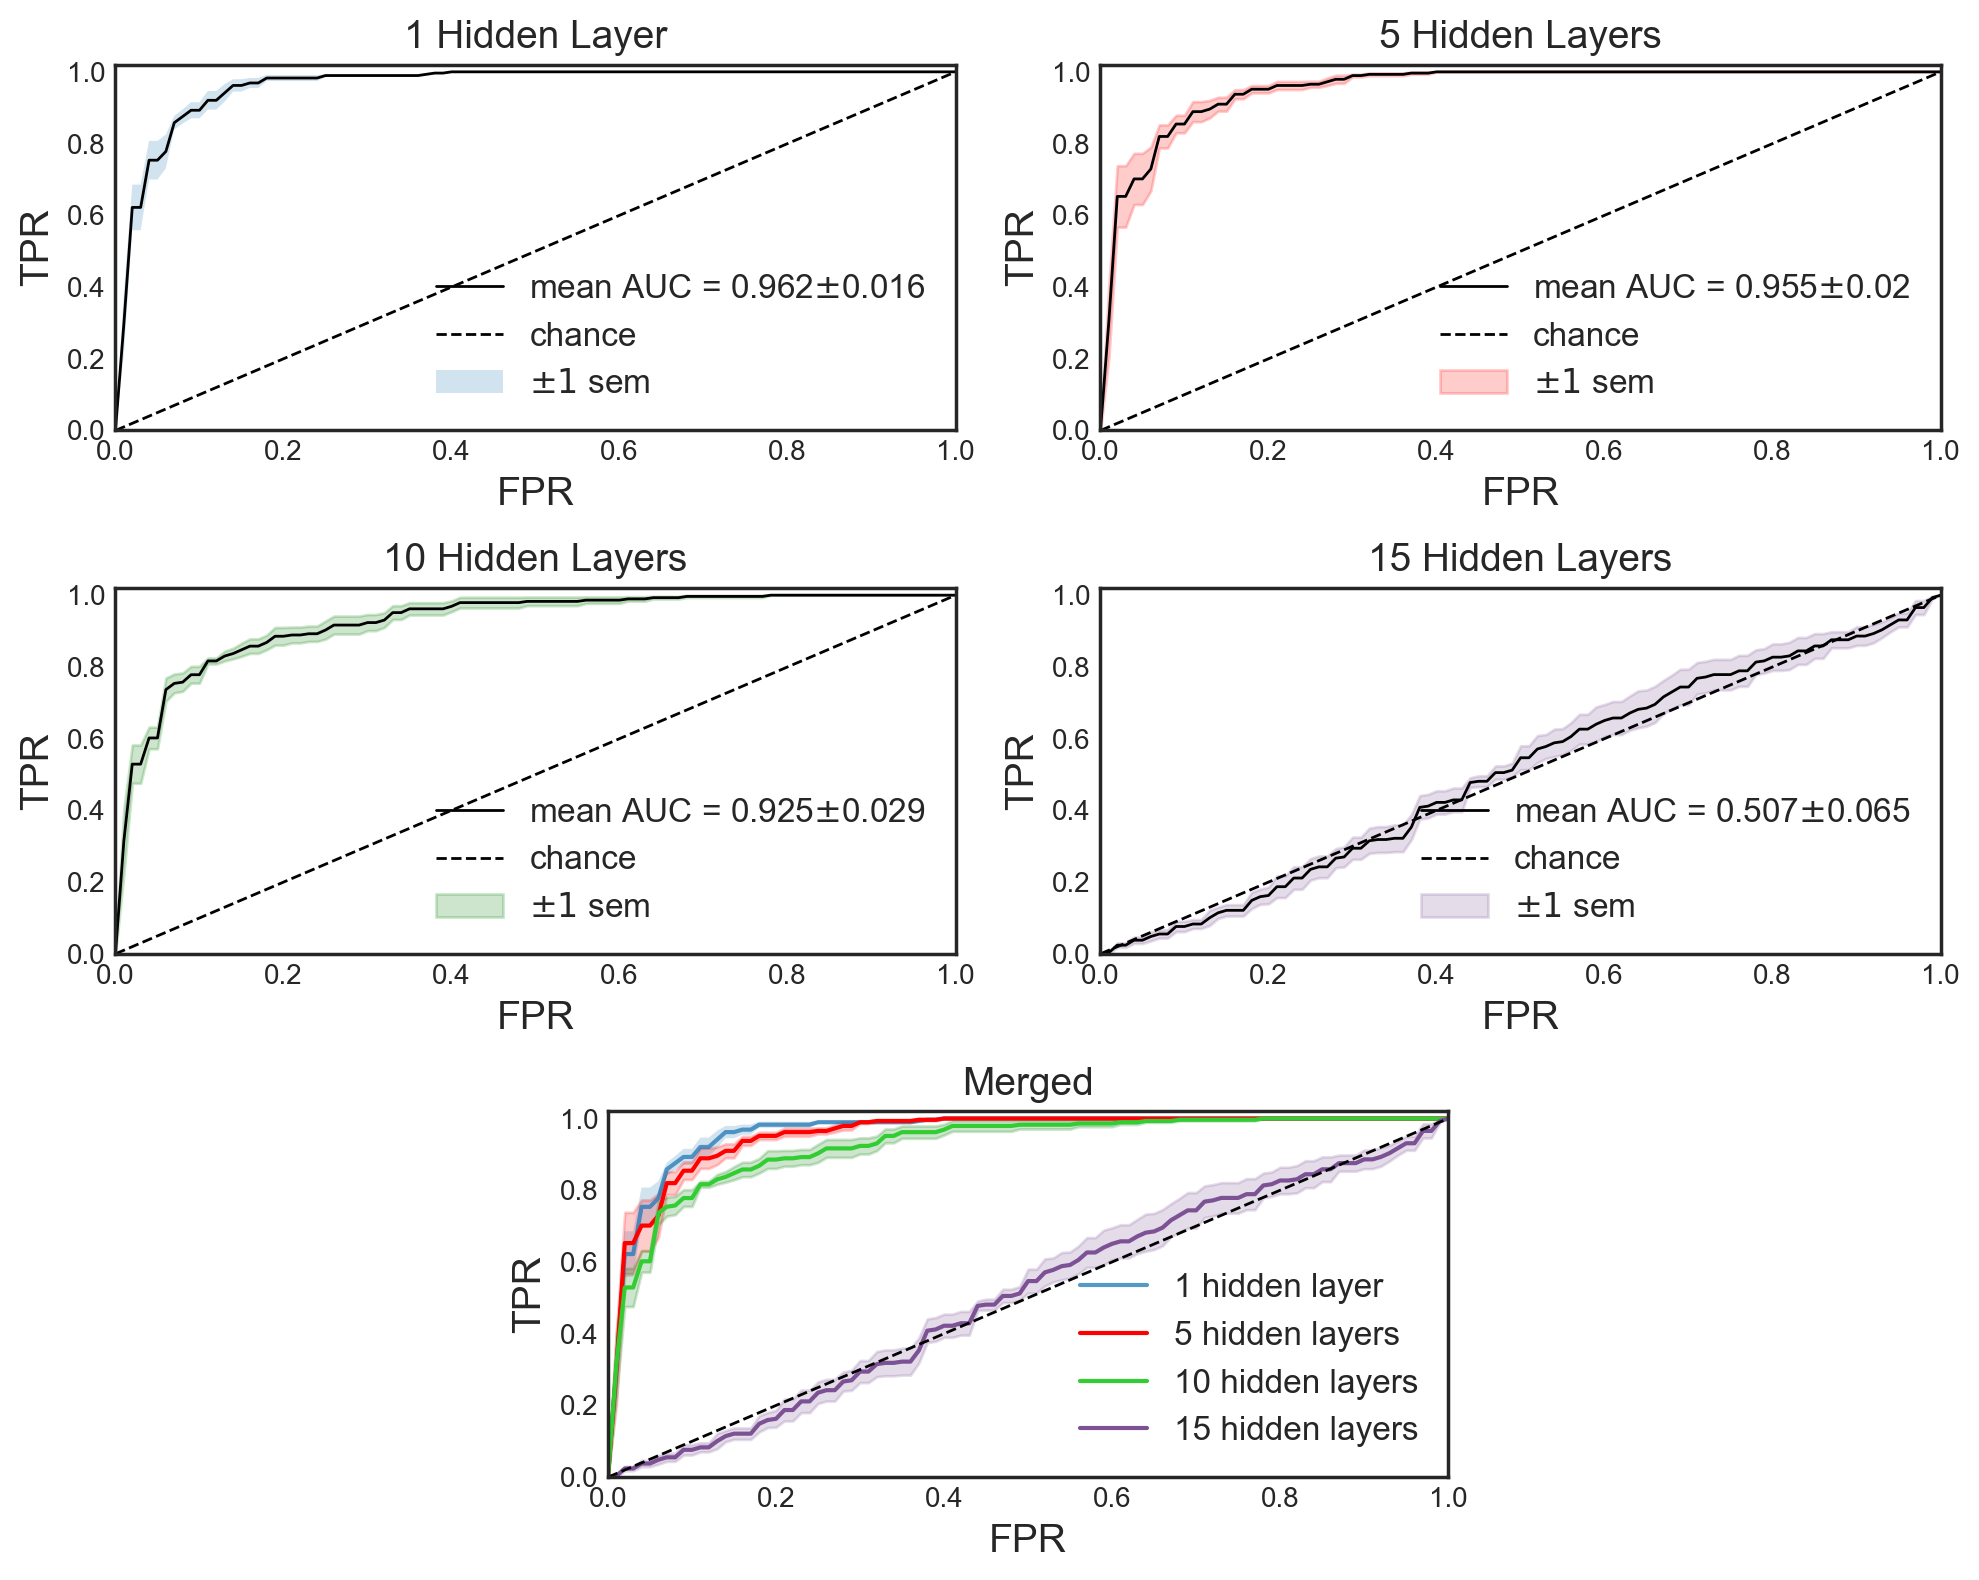

In [197]:
plt.style.use('seaborn-white')
plt.rcParams.update({'font.size': 10})

# combined figure
fig = plt.figure(figsize=(10,8), dpi=200)
spec = gridspec.GridSpec(ncols=4, nrows=3, figure=fig)
ax1 = fig.add_subplot(spec[0, :2])
ax2 = fig.add_subplot(spec[0, 2:])
ax3 = fig.add_subplot(spec[1, :2])
ax4 = fig.add_subplot(spec[1, 2:])
ax5 = fig.add_subplot(spec[2, 1:3])

# 1 hidden layer
ax1.plot(base_fpr1, mean_tprs1, 'k', linewidth=1)
ax1.fill_between(base_fpr1, tprs_lower1, tprs_upper1, alpha=0.2)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.02])
ax1.set_title('1 Hidden Layer', fontsize=14)
ax1.set_ylabel('TPR', fontsize=14)
ax1.set_xlabel('FPR', fontsize=14)
ax1.legend(['mean AUC = ' + str(round(auc1, 3)) + '$\pm$' + str(round(np.mean(std1), 3)),
            'chance', '$\pm 1$ sem'],
           fontsize=12, loc='lower right')
# ax1.text(-.1, 1.1, 'B', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# 5 hidden layers
ax2.plot(base_fpr5, mean_tprs5, color='k', linewidth=1)
ax2.fill_between(base_fpr5, tprs_lower5, tprs_upper5, alpha=0.2, color='r')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1.02])
ax2.set_title('5 Hidden Layers', fontsize=14)
ax2.set_ylabel('TPR', fontsize=14)
ax2.set_xlabel('FPR', fontsize=14)
ax2.legend(['mean AUC = ' + str(round(auc5, 3)) + '$\pm$' + str(round(np.mean(std5), 3)),
            'chance', '$\pm 1$ sem'],
           fontsize=12, loc='lower right')

# 10 hidden layers
ax3.plot(base_fpr10, mean_tprs10, color='k', linewidth=1)
ax3.fill_between(base_fpr10, tprs_lower10, tprs_upper10, alpha=0.2, color='g')
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1.02])
ax3.set_title('10 Hidden Layers', fontsize=14)
ax3.set_ylabel('TPR', fontsize=14)
ax3.set_xlabel('FPR', fontsize=14)
ax3.legend(['mean AUC = ' + str(round(auc10, 3)) + '$\pm$' + str(round(np.mean(std10), 3)),
            'chance', '$\pm 1$ sem'],
           fontsize=12, loc='lower right')

# 15 hidden layers
ax4.plot(base_fpr15, mean_tprs15, color='k', linewidth=1)
ax4.fill_between(base_fpr15, tprs_lower15, tprs_upper15, alpha=0.2, color='#7c5295')
ax4.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax4.set_xlim([0, 1])
ax4.set_ylim([0, 1.02])
ax4.set_title('15 Hidden Layers', fontsize=14)
ax4.set_ylabel('TPR', fontsize=14)
ax4.set_xlabel('FPR', fontsize=14)
ax4.legend(['mean AUC = ' + str(round(auc15, 3)) + '$\pm$' + str(round(np.mean(std15), 3)),
            'chance', '$\pm 1$ sem'],
           fontsize=12, loc='lower right')

# merged
## 1
ax5.plot(base_fpr1, mean_tprs1, linewidth=1.5, alpha=0.75)
ax5.fill_between(base_fpr1, tprs_lower1, tprs_upper1, alpha=0.2)
## 5
ax5.plot(base_fpr5, mean_tprs5, '#ff0000', linewidth=1.5, alpha=1)
ax5.fill_between(base_fpr5, tprs_lower5, tprs_upper5, alpha=0.2, color='r')
# 10
ax5.plot(base_fpr10, mean_tprs10, '#32CD32', linewidth=1.5, alpha=1)
ax5.fill_between(base_fpr10, tprs_lower10, tprs_upper10, alpha=0.2, color='g')
## 15
ax5.plot(base_fpr15, mean_tprs15, '#7c5295', linewidth=1.5, alpha=1)
ax5.fill_between(base_fpr15, tprs_lower15, tprs_upper15, alpha=0.2, color='#7c5295')

# overall graph
ax5.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax5.set_xlim([0, 1])
ax5.set_ylim([0, 1.02])
ax5.set_title('Merged', fontsize=14)
ax5.set_ylabel('TPR', fontsize=14)
ax5.set_xlabel('FPR', fontsize=14)
ax5.legend(['1 hidden layer', '5 hidden layers', '10 hidden layers', '15 hidden layers'], fontsize=12, loc='lower right')

fig.tight_layout()

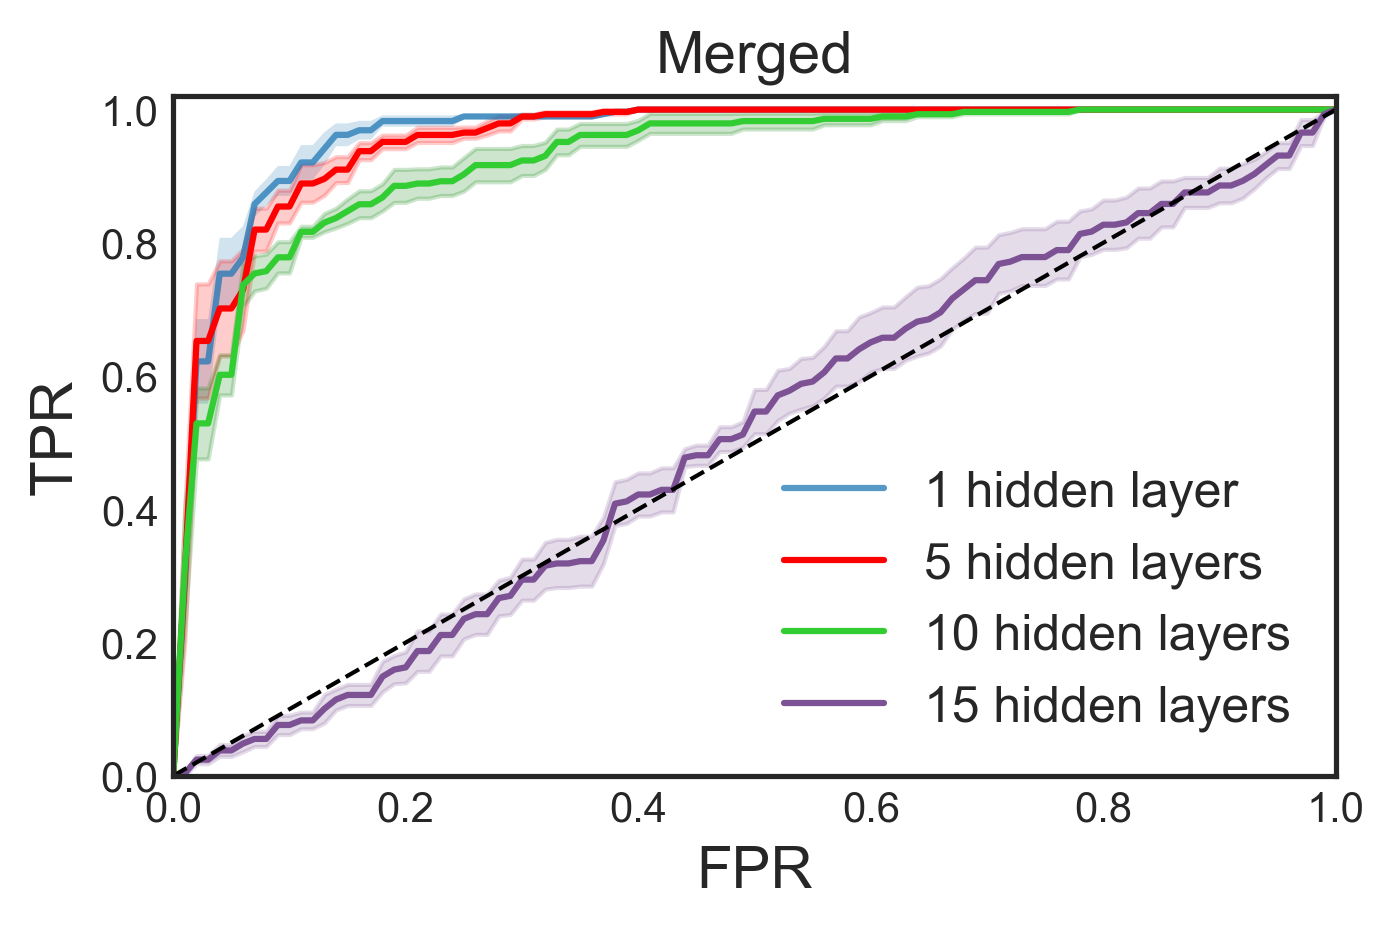

In [192]:
fig = plt.figure(figsize=(5,3), dpi=300)
ax5 = fig.add_subplot()

# merged
## 1
ax5.plot(base_fpr1, mean_tprs1, linewidth=1.5, alpha=0.75)
ax5.fill_between(base_fpr1, tprs_lower1, tprs_upper1, alpha=0.2)
## 5
ax5.plot(base_fpr5, mean_tprs5, '#ff0000', linewidth=1.5, alpha=1)
ax5.fill_between(base_fpr5, tprs_lower5, tprs_upper5, alpha=0.2, color='r')
# 10
ax5.plot(base_fpr10, mean_tprs10, '#32CD32', linewidth=1.5, alpha=1)
ax5.fill_between(base_fpr10, tprs_lower10, tprs_upper10, alpha=0.2, color='g')
## 15
ax5.plot(base_fpr15, mean_tprs15, '#7c5295', linewidth=1.5, alpha=1)
ax5.fill_between(base_fpr15, tprs_lower15, tprs_upper15, alpha=0.2, color='#7c5295')

# overall graph
ax5.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax5.set_xlim([0, 1])
ax5.set_ylim([0, 1.02])
ax5.set_title('Merged', fontsize=14)
ax5.set_ylabel('TPR', fontsize=14)
ax5.set_xlabel('FPR', fontsize=14)
ax5.legend(['1 hidden layer', '5 hidden layers', '10 hidden layers', '15 hidden layers'], fontsize=12, loc='lower right')

# Final Model

## Evaluating the Final Model

In [26]:
y_pred1 = model1.predict(X_test)
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85        63
           1       0.78      0.85      0.81        46

    accuracy                           0.83       109
   macro avg       0.83      0.84      0.83       109
weighted avg       0.84      0.83      0.84       109



In [27]:
y_pred5 = model5.predict(X_test)
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.95      0.63      0.76        63
           1       0.66      0.96      0.78        46

    accuracy                           0.77       109
   macro avg       0.80      0.80      0.77       109
weighted avg       0.83      0.77      0.77       109



In [28]:
y_pred10 = model10.predict(X_test)
print(classification_report(y_test, y_pred10))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        63
           1       0.86      0.83      0.84        46

    accuracy                           0.87       109
   macro avg       0.87      0.87      0.87       109
weighted avg       0.87      0.87      0.87       109



In [29]:
y_pred15 = model15.predict(X_test)
print(classification_report(y_test, y_pred15))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62        63
           1       0.44      0.37      0.40        46

    accuracy                           0.53       109
   macro avg       0.51      0.51      0.51       109
weighted avg       0.52      0.53      0.53       109



## Confusion Matrices

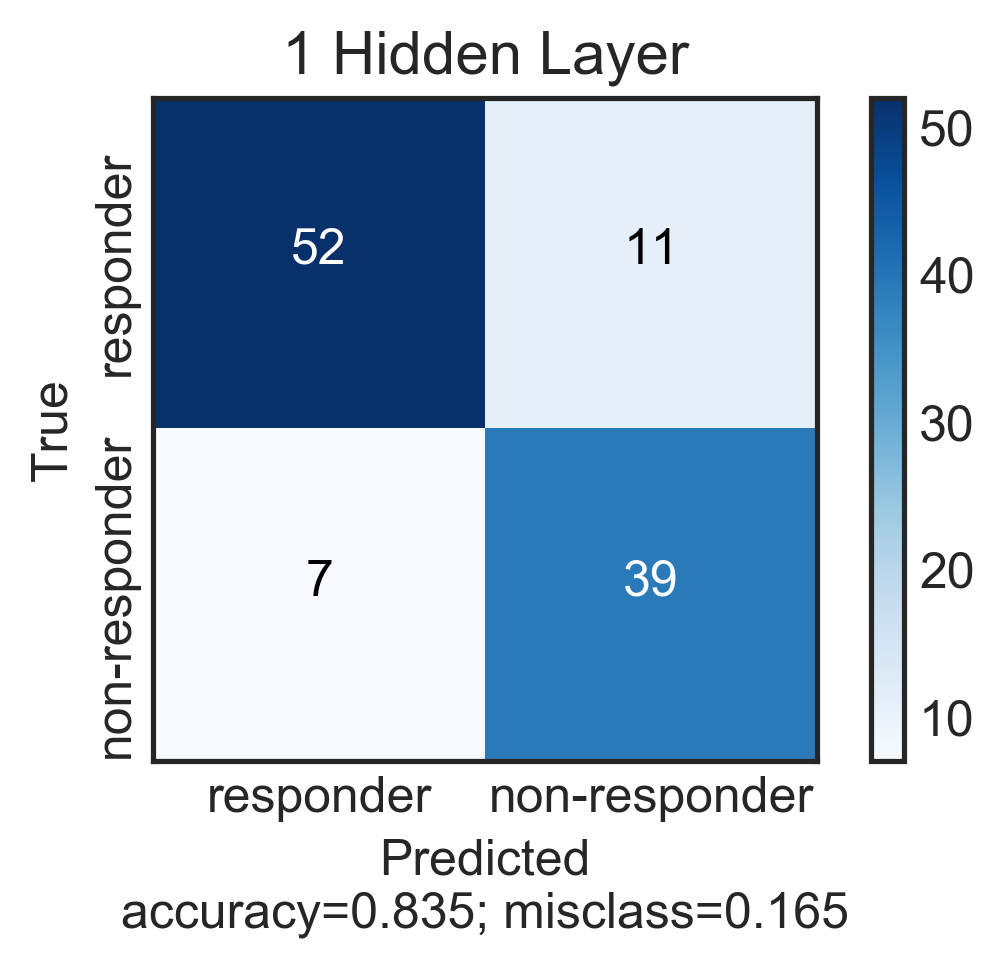

In [170]:
fcm1 = confusion_matrix(y_test, y_pred1)
plt.rcParams.update({'font.size': 12})
fcm_hidden1 = plot_confusion_matrix(fcm1, ['responder', 'non-responder'], title='1 Hidden Layer', normalize=False)

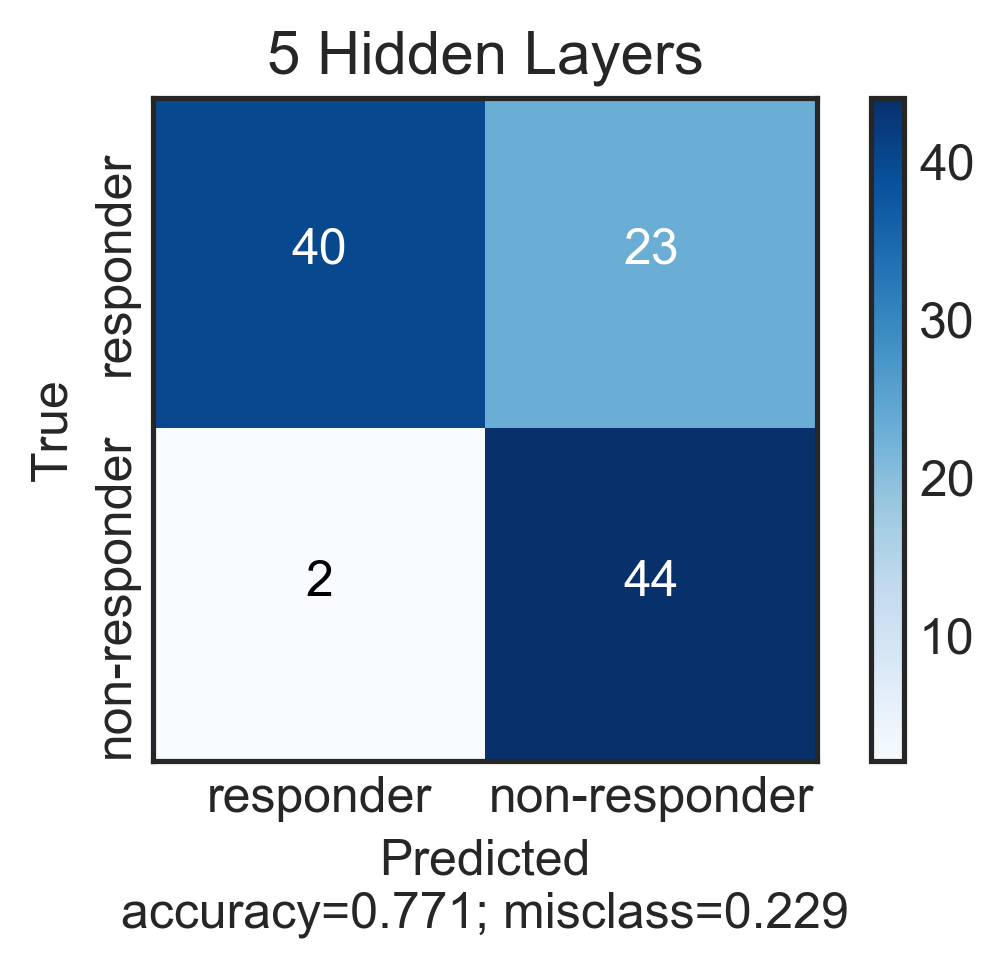

In [172]:
fcm5 = confusion_matrix(y_test, y_pred5)
plt.rcParams.update({'font.size': 12})
fcm_hidden5 = plot_confusion_matrix(fcm5, ['responder', 'non-responder'], title='5 Hidden Layers', normalize=False)

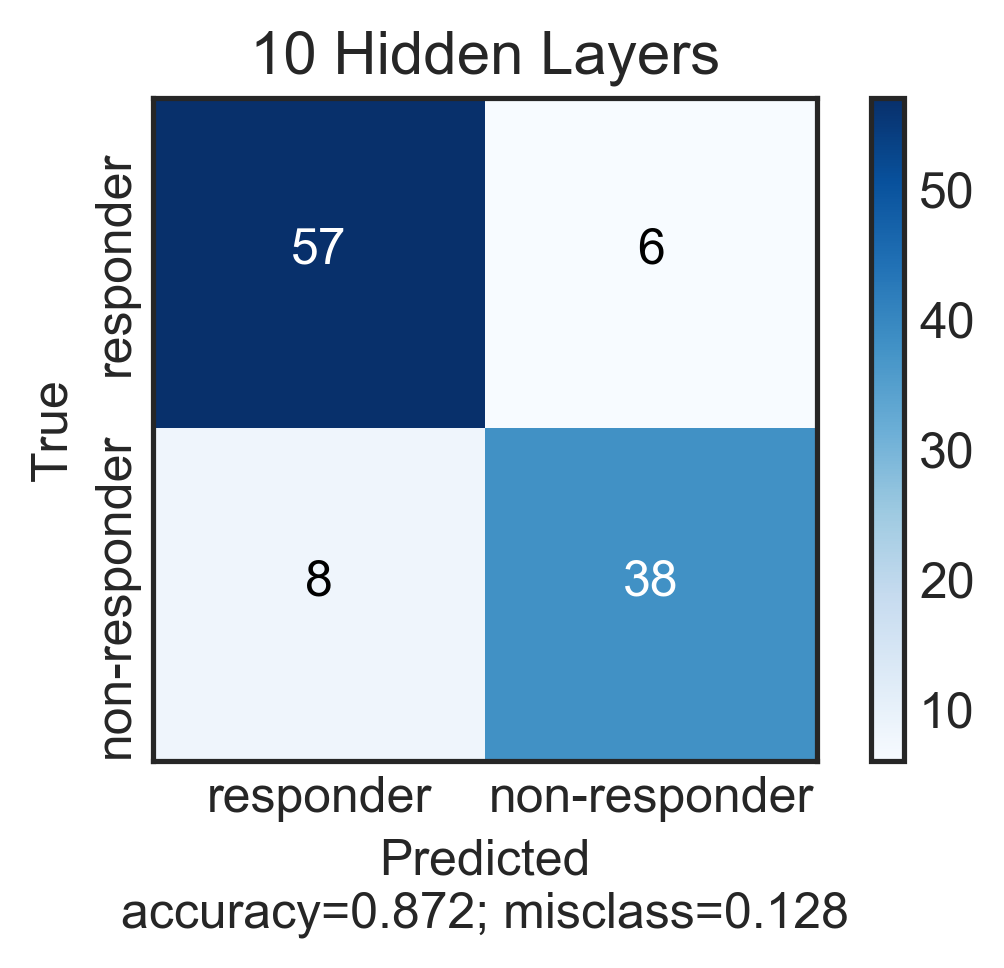

In [173]:
fcm10 = confusion_matrix(y_test, y_pred10)
plt.rcParams.update({'font.size': 12})
fcm_hidden10 = plot_confusion_matrix(fcm10, ['responder', 'non-responder'], title='10 Hidden Layers', normalize=False)

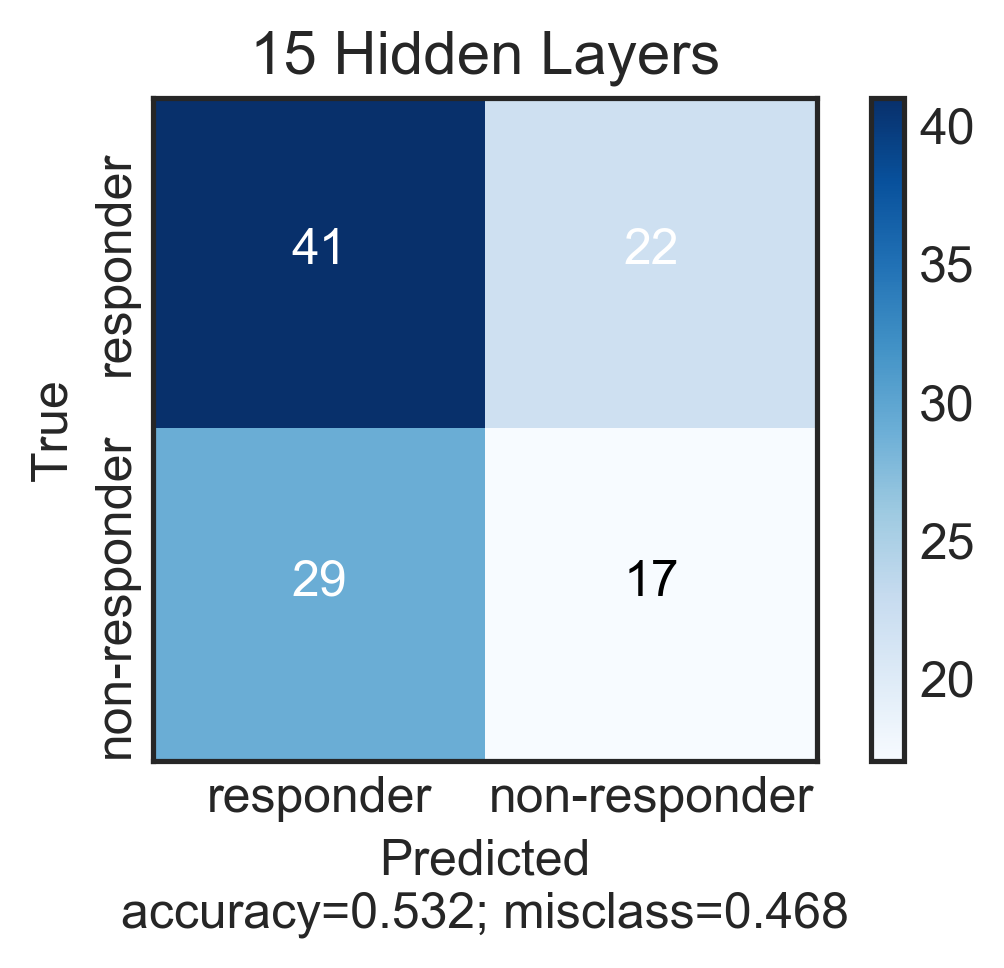

In [174]:
fcm15 = confusion_matrix(y_test, y_pred15)
plt.rcParams.update({'font.size': 12})
fcm_hidden15 = plot_confusion_matrix(fcm15, ['responder', 'non-responder'], title='15 Hidden Layers', normalize=False, cbar=True)

## Comparison Plots

In [35]:
def make_roc(model, X, y):
    base_fpr = np.linspace(0, 1, 101)
    y_score = model.predict_proba(X)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    tpr = np.interp(base_fpr, fpr, tpr)
    return base_fpr, tpr

In [40]:
fbase_fpr1, ftpr1 = make_roc(model1, X_test.values, y_test.values)
# for 1 hidden layer
ftprs1 = np.array(ftpr1)
fauc1 = auc(fbase_fpr1, ftprs1)

In [42]:
fbase_fpr5, ftpr5 = make_roc(model5, X_test.values, y_test.values)
# for 5 hidden layers
ftprs5 = np.array(ftpr5)
fauc5 = auc(fbase_fpr5, ftprs5)

In [43]:
fbase_fpr10, ftpr10 = make_roc(model10, X_test.values, y_test.values)
# for 10 hidden layers
ftprs10 = np.array(ftpr10)
fauc10 = auc(fbase_fpr10, ftprs10)

In [44]:
fbase_fpr15, ftpr15 = make_roc(model15, X_test.values, y_test.values)
# for 15 hidden layers
ftprs15 = np.array(ftpr15)
fauc15 = auc(fbase_fpr15, ftprs15)

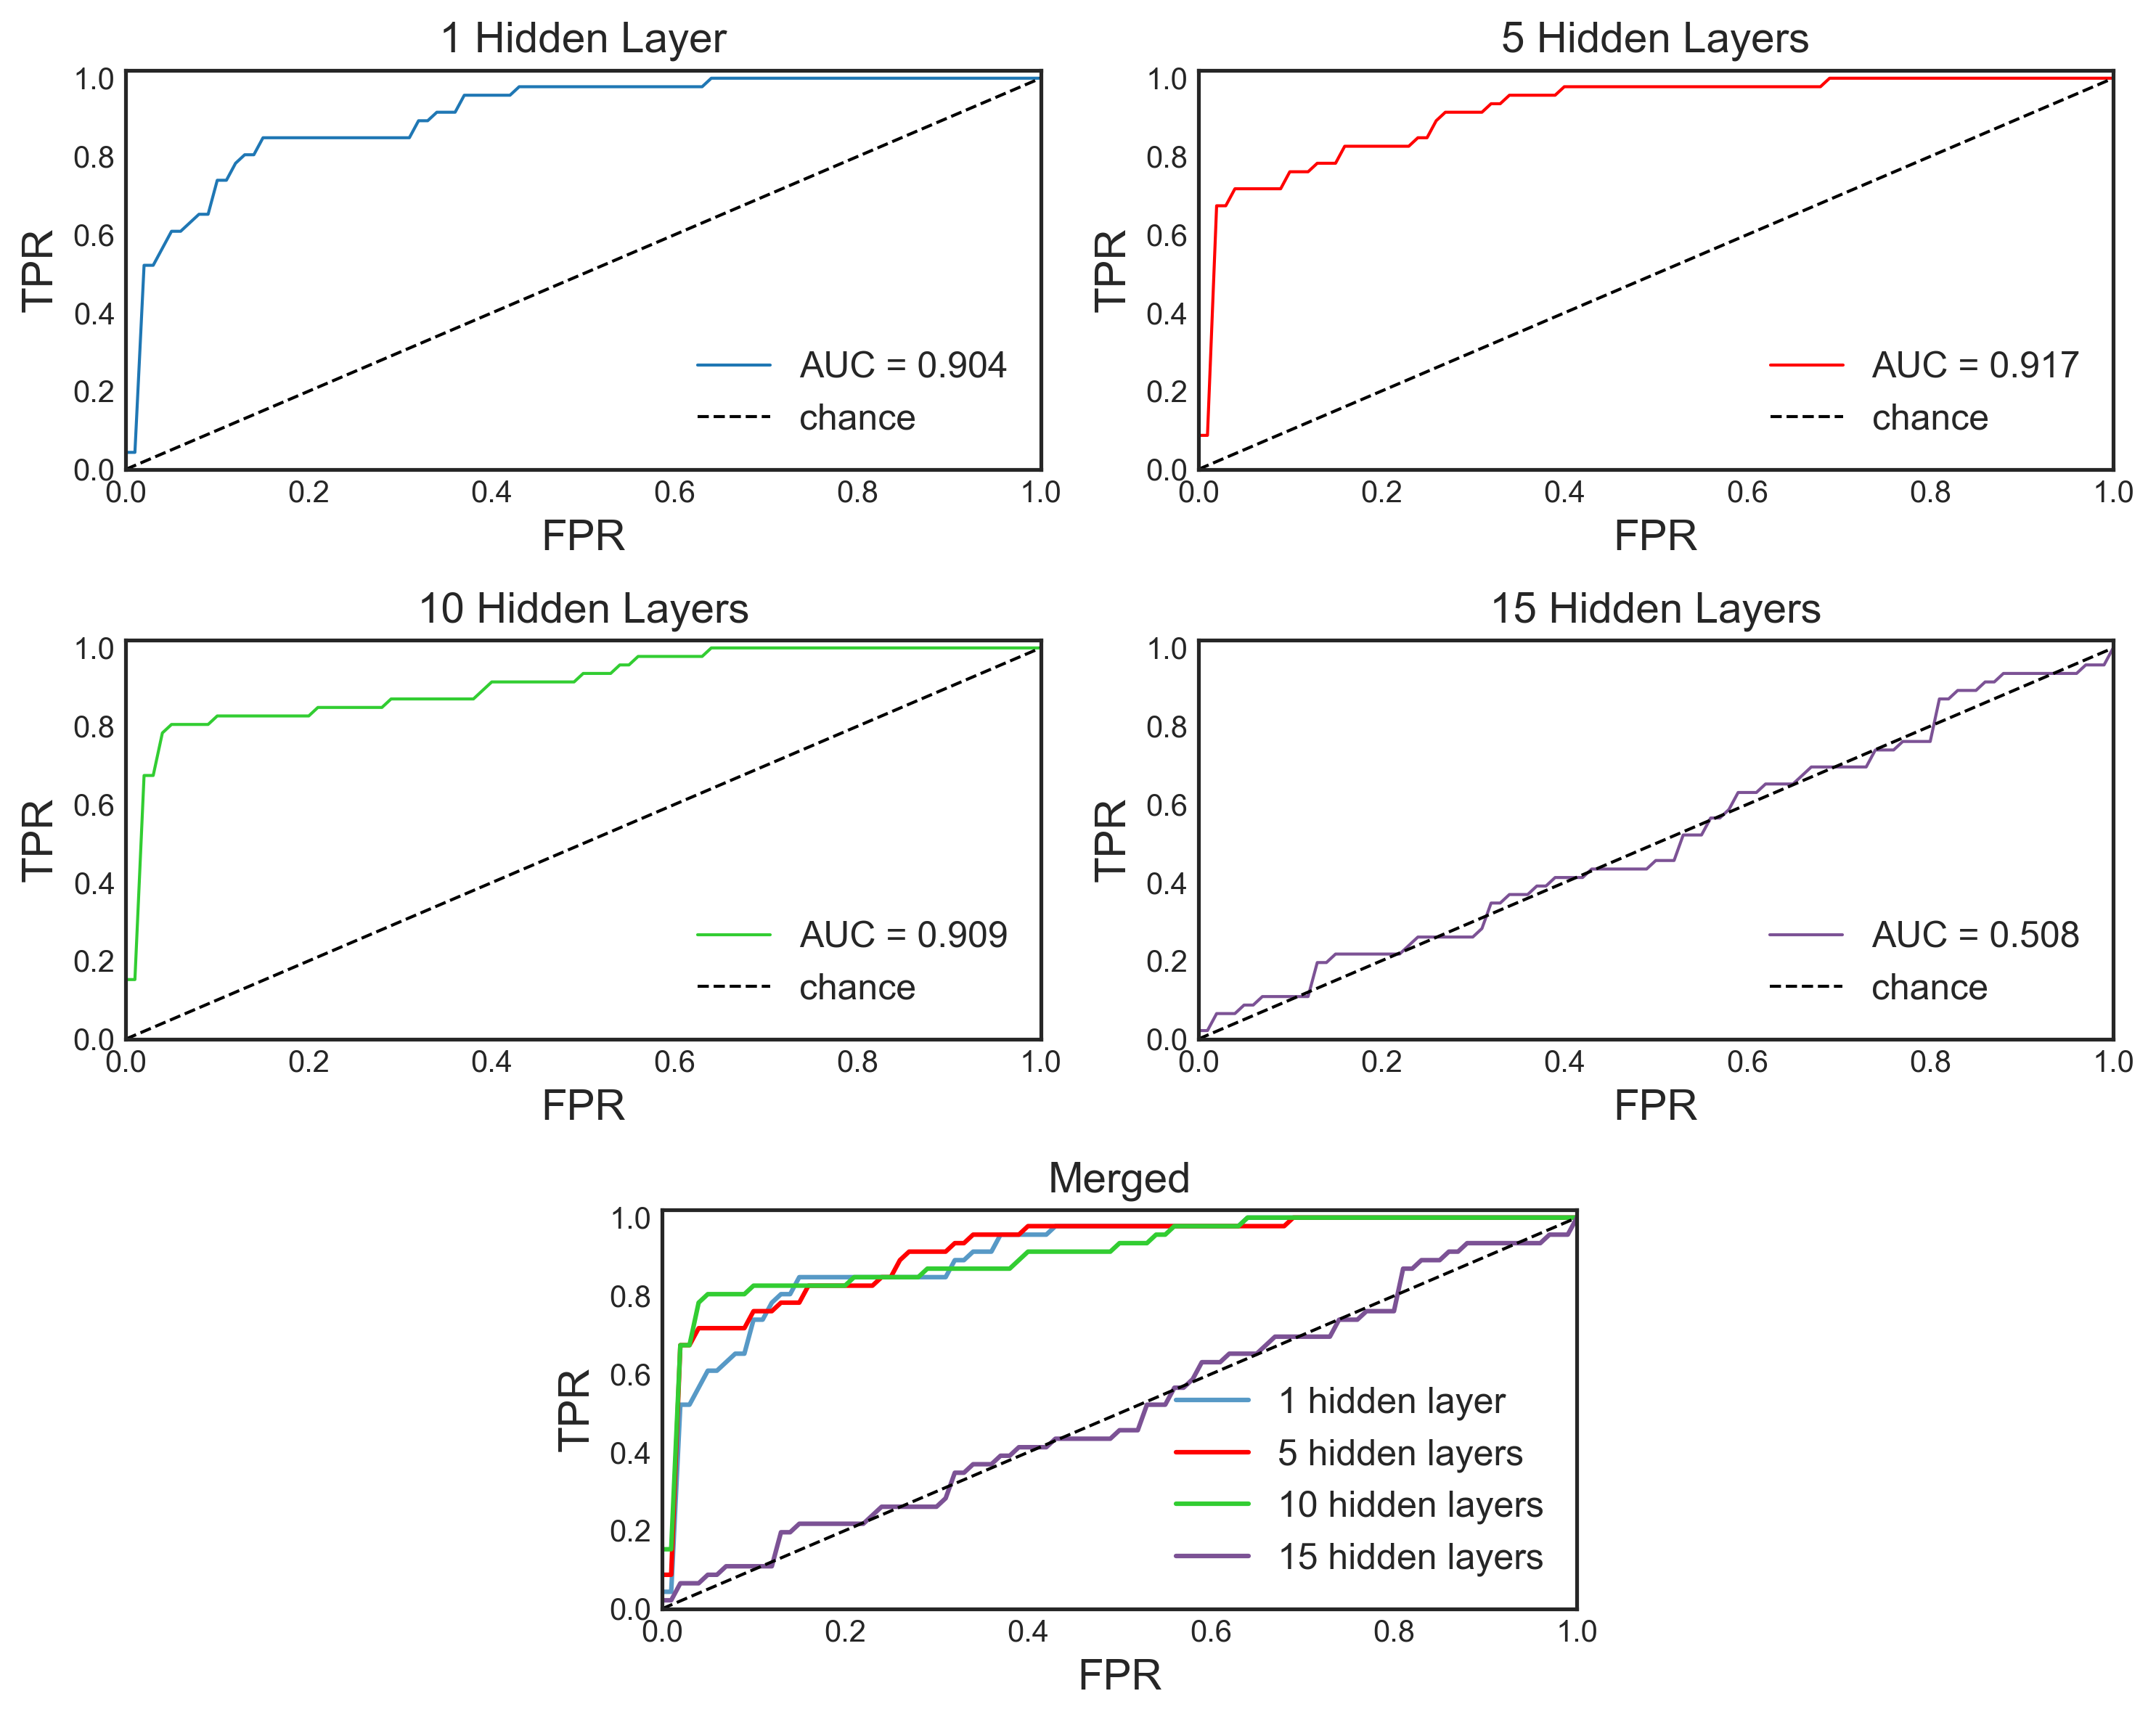

In [196]:
plt.style.use('seaborn-white')

plt.rcParams.update({'font.size': 10})
# combined figure
ffig = plt.figure(figsize=(10,8), dpi=300)
fspec = gridspec.GridSpec(ncols=4, nrows=3, figure=ffig)
ax1 = ffig.add_subplot(spec[0, :2])
ax2 = ffig.add_subplot(spec[0, 2:])
ax3 = ffig.add_subplot(spec[1, :2])
ax4 = ffig.add_subplot(spec[1, 2:])
ax5 = ffig.add_subplot(spec[2, 1:3])

# 1 hidden layer
ax1.plot(fbase_fpr1, ftprs1, linewidth=1)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.02])
ax1.set_title('1 Hidden Layer', fontsize=14)
ax1.set_ylabel('TPR', fontsize=14)
ax1.set_xlabel('FPR', fontsize=14)
ax1.legend(['AUC = ' + str(round(fauc1, 3)), 'chance'], fontsize=12, loc='lower right')
# ax1.text(-.1, 1.1, 'B', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# 5 hidden layers
ax2.plot(fbase_fpr5, ftprs5, color='#ff0000', linewidth=1)
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1.02])
ax2.set_title('5 Hidden Layers', fontsize=14)
ax2.set_ylabel('TPR', fontsize=14)
ax2.set_xlabel('FPR', fontsize=14)
ax2.legend(['AUC = ' + str(round(fauc5, 3)), 'chance'], fontsize=12, loc='lower right')

# 10 hidden layers
ax3.plot(fbase_fpr10, ftprs10, color='#32CD32', linewidth=1)
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1.02])
ax3.set_title('10 Hidden Layers', fontsize=14)
ax3.set_ylabel('TPR', fontsize=14)
ax3.set_xlabel('FPR', fontsize=14)
ax3.legend(['AUC = ' + str(round(fauc10, 3)), 'chance'], fontsize=12, loc='lower right')

# 15 hidden layers
ax4.plot(fbase_fpr15, ftprs15, color='#7c5295', linewidth=1)
ax4.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax4.set_xlim([0, 1])
ax4.set_ylim([0, 1.02])
ax4.set_title('15 Hidden Layers', fontsize=14)
ax4.set_ylabel('TPR', fontsize=14)
ax4.set_xlabel('FPR', fontsize=14)
ax4.legend(['AUC = ' + str(round(fauc15, 3)), 'chance'], fontsize=12, loc='lower right')

# merged
## 1
ax5.plot(fbase_fpr1, ftprs1, linewidth=1.5, alpha=0.75)
## 5
ax5.plot(fbase_fpr5, ftprs5, '#ff0000', linewidth=1.5, alpha=1)
# 10
ax5.plot(fbase_fpr10, ftprs10, '#32CD32', linewidth=1.5, alpha=1)
## 15
ax5.plot(fbase_fpr15, ftprs15, '#7c5295', linewidth=1.5, alpha=1)

# overall graph
ax5.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax5.set_xlim([0, 1])
ax5.set_ylim([0, 1.02])
ax5.set_title('Merged', fontsize=14)
ax5.set_ylabel('TPR', fontsize=14)
ax5.set_xlabel('FPR', fontsize=14)
ax5.legend(['1 hidden layer', '5 hidden layers', '10 hidden layers', '15 hidden layers'], fontsize=12, loc='lower right')

ffig.tight_layout()

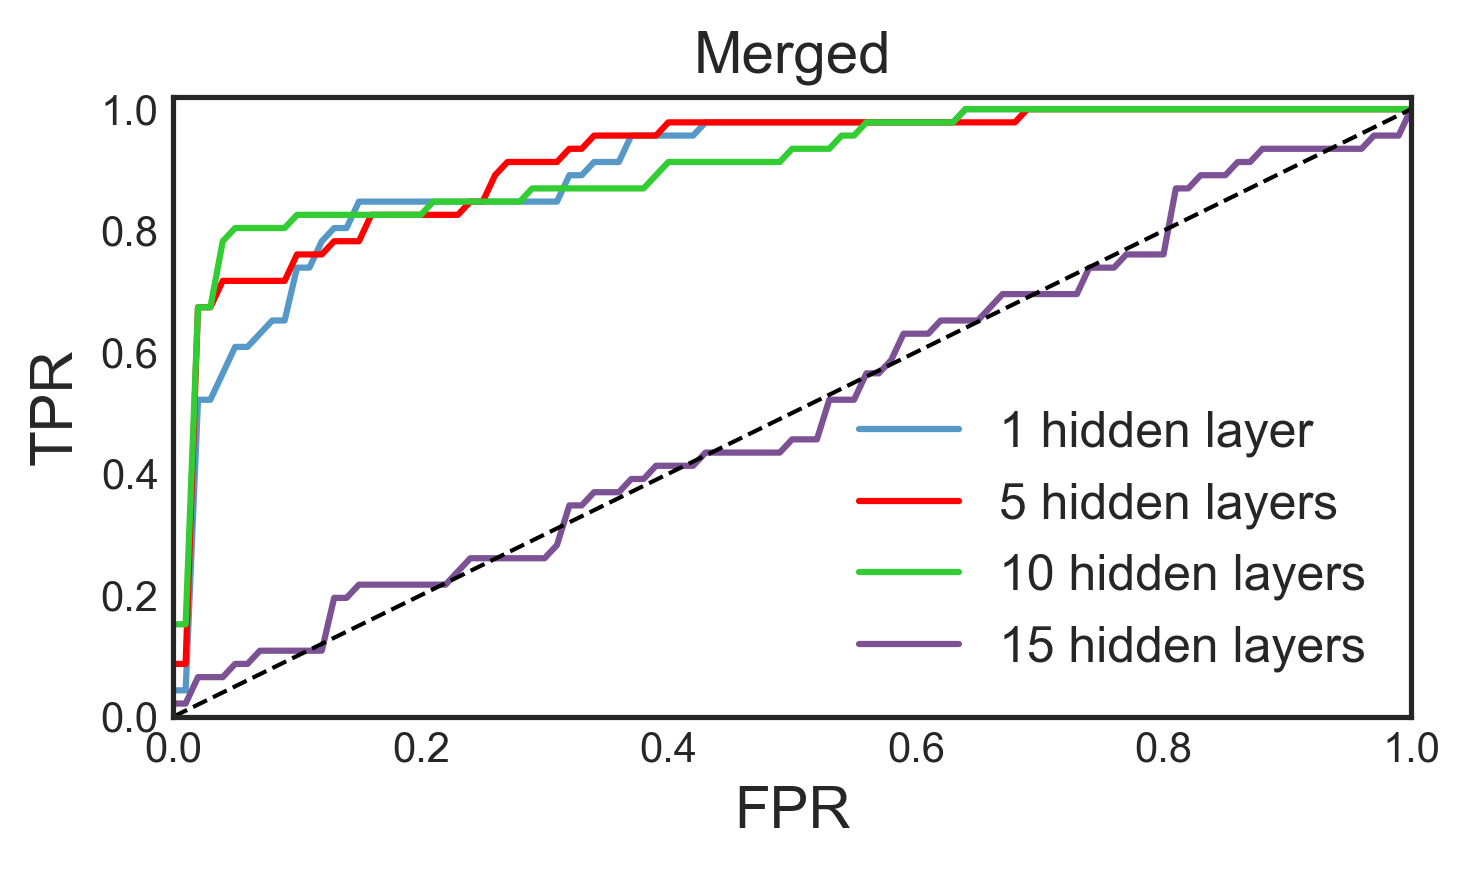

In [195]:
ffig = plt.figure(figsize=(5,3), dpi=300)
ax5 = ffig.add_subplot()

# merged
## 1
ax5.plot(fbase_fpr1, ftprs1, linewidth=1.5, alpha=0.75)
## 5
ax5.plot(fbase_fpr5, ftprs5, '#ff0000', linewidth=1.5, alpha=1)
# 10
ax5.plot(fbase_fpr10, ftprs10, '#32CD32', linewidth=1.5, alpha=1)
## 15
ax5.plot(fbase_fpr15, ftprs15, '#7c5295', linewidth=1.5, alpha=1)

# overall graph
ax5.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax5.set_xlim([0, 1])
ax5.set_ylim([0, 1.02])
ax5.set_title('Merged', fontsize=14)
ax5.set_ylabel('TPR', fontsize=14)
ax5.set_xlabel('FPR', fontsize=14)
ax5.legend(['1 hidden layer', '5 hidden layers', '10 hidden layers', '15 hidden layers'], fontsize=12, loc='lower right')

ffig.tight_layout()

## Saving the Final Model

In [166]:
model1.model.save('models/hidden1/')

INFO:tensorflow:Assets written to: models/hidden1/assets


In [167]:
model5.model.save('models/hidden5/')

INFO:tensorflow:Assets written to: models/hidden5/assets


In [168]:
model10.model.save('models/hidden10/')

INFO:tensorflow:Assets written to: models/hidden10/assets


In [169]:
model15.model.save('models/hidden15/')

INFO:tensorflow:Assets written to: models/hidden15/assets
